In [104]:
from datasets import load_dataset
import pandas as pd
dataset = load_dataset("autogluon/chronos_datasets", "m4_weekly")
df = pd.DataFrame(dataset['train'])
print(df.head())

        id                                          timestamp  \
0  T000000  [1975-08-03 12:00:00, 1975-08-10 12:00:00, 197...   
1  T000001  [1984-04-01 12:00:00, 1984-04-08 12:00:00, 198...   
2  T000002  [1975-06-01 12:00:00, 1975-06-08 12:00:00, 197...   
3  T000003  [1967-07-02 12:00:00, 1967-07-09 12:00:00, 196...   
4  T000004  [1986-08-03 12:00:00, 1986-08-10 12:00:00, 198...   

                                              target category  
0  [1089.2, 1078.91, 1079.88, 1063.58, 1060.61, 1...    Other  
1  [195.928, 194.796, 192.71, 190.288, 188.77, 18...    Other  
2  [258.7, 259.8, 260.2, 260.8, 261.1, 263.1, 264...    Other  
3  [3460.0, 3340.0, 2770.0, 2520.0, 2740.0, 2760....    Other  
4  [4696.0, 4765.0, 4144.0, 3945.0, 4733.0, 4330....    Other  


In [105]:
print(f"shape of df: {df.shape}")

shape of df: (359, 4)


In [106]:
print(f"columns of df: {df.columns.to_list()}")

columns of df: ['id', 'timestamp', 'target', 'category']


In [107]:
print(f"data types: {df.dtypes}")

data types: id           object
timestamp    object
target       object
category     object
dtype: object


In [108]:
print(f"missing values :\n{df.isnull().sum()}")

missing values :
id           0
timestamp    0
target       0
category     0
dtype: int64


In [109]:
#converting to long format
import datasets

def to_pandas(ds: datasets.Dataset) -> "pd.DataFrame":
    """Convert dataset to long data frame format."""
    sequence_columns = [col for col in ds.features if isinstance(ds.features[col], datasets.Sequence)]
    return ds.to_pandas().explode(sequence_columns).infer_objects()

data = to_pandas(dataset['train'])
data

,id,timestamp,target,category
0,T000000,1975-08-03 12:00:00,1089.20,Other
0,T000000,1975-08-10 12:00:00,1078.91,Other
0,T000000,1975-08-17 12:00:00,1079.88,Other
0,T000000,1975-08-24 12:00:00,1063.58,Other
0,T000000,1975-08-31 12:00:00,1060.61,Other
...,...,...,...,...
358,T000358,2017-09-10 12:00:00,3386.00,Micro
358,T000358,2017-09-17 12:00:00,3627.00,Micro
358,T000358,2017-09-24 12:00:00,3299.00,Micro
358,T000358,2017-10-01 12:00:00,3743.00,Micro


In [110]:
data.to_csv("e:/proj/m4_weekly_long.csv", index=False)

<Axes: >

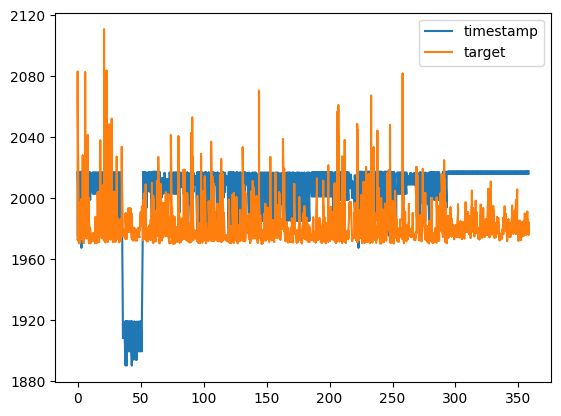

In [111]:
data.plot()

In [112]:
# Expected columns: series identifier, time index, value
possible_id_cols = ['item_id', 'series_id', 'id']
possible_time_cols = ['time_idx', 'timestamp', 'time', 'index']
possible_value_cols = ['value', 'target']

In [113]:
# Find actual column names
id_col = next((col for col in possible_id_cols if col in data.columns), None)
time_col = next((col for col in possible_time_cols if col in data.columns), None)
value_col = next((col for col in possible_value_cols if col in data.columns), None)

if id_col is None:
    print("Warning: No series identifier found. Assuming single series.")
    data['item_id'] = 'single_series'
    id_col = 'item_id'
if time_col is None:
    print("Warning: No time column found. Adding time_idx.")
    data['time_idx'] = range(len(data))
    time_col = 'time_idx'
if value_col is None:
    raise ValueError("No value column found. Please check the dataset.")

In [114]:
# Rename to standard names
data = data.rename(columns={id_col: 'item_id', time_col: 'time_idx', value_col: 'value'})
data = data[['item_id', 'time_idx', 'value']].dropna()
print("Standardized data. Shape:", data.shape)
print(data.head())

Standardized data. Shape: (371579, 3)
   item_id            time_idx    value
0  T000000 1975-08-03 12:00:00  1089.20
0  T000000 1975-08-10 12:00:00  1078.91
0  T000000 1975-08-17 12:00:00  1079.88
0  T000000 1975-08-24 12:00:00  1063.58
0  T000000 1975-08-31 12:00:00  1060.61


In [151]:
# Enhanced feature engineering
def create_features(df, group_col='item_id', value_col='value'):
    df = df.copy()
    for lag in [1, 2, 3, 4]:
        df[f'lag_{lag}'] = df.groupby(group_col)[value_col].shift(lag)
    df['rolling_mean_4'] = df.groupby(group_col)[value_col].rolling(window=4, min_periods=1).mean().reset_index(level=0, drop=True)
    df['rolling_std_4'] = df.groupby(group_col)[value_col].rolling(window=4, min_periods=1).std().reset_index(level=0, drop=True)
    df['trend'] = df.groupby(group_col)[value_col].cumcount()  # Simple trend feature
    return df.dropna()

print("Adding features...")
df_features = create_features(data)
print("Data range:", df_features['value'].describe())
feature_cols = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'rolling_mean_4', 'rolling_std_4', 'trend']


Adding features...
Data range: count    370143.000000
mean       3839.453968
std        3546.091004
min         104.690000
25%        1480.002500
50%        2690.500000
75%        5080.000000
max       51410.000000
Name: value, dtype: float64


In [152]:
df_features.head()

,item_id,time_idx,value,lag_1,lag_2,lag_3,lag_4,rolling_mean_4,rolling_std_4,trend
0,T000000,1975-08-31 12:00:00,1060.61,1063.58,1079.88,1078.91,1089.20,1070.7450,10.069275,4
0,T000000,1975-09-07 12:00:00,1056.93,1060.61,1063.58,1079.88,1078.91,1065.2500,10.125509,5
0,T000000,1975-09-14 12:00:00,1056.63,1056.93,1060.61,1063.58,1079.88,1059.4375,3.301751,6
0,T000000,1975-09-21 12:00:00,1049.51,1056.63,1056.93,1060.61,1063.58,1055.9200,4.640704,7
0,T000000,1975-09-28 12:00:00,1049.32,1049.51,1056.63,1056.93,1060.61,1053.0975,4.254655,8


In [153]:
from sklearn.model_selection import TimeSeriesSplit
# --- Time Series Forecasting ---
X = df_features[feature_cols]
y = df_features['value']
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import joblib
import plotly.graph_objects as go

rmse_scores, mae_scores, smape_scores = [], [], []
last_fold_data = None

print("Running cross-validation on full dataset...")
for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = XGBRegressor(
        n_estimators=100,      # Reduced for speed
        learning_rate=0.05,    # Slower learning
        max_depth=5,           # Reduced depth
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
    )
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    smape = 200 * np.mean(np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred)))
    
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    smape_scores.append(smape)
    
    print(f"Fold {fold + 1}: RMSE={rmse:.4f}, MAE={mae:.4f}, sMAPE={smape:.4f}")

# --- Results ---
print("\n=== Cross-Validation Results ===")
print(f"Average RMSE: {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")
print(f"Average MAE: {np.mean(mae_scores):.4f} (±{np.std(mae_scores):.4f})")
print(f"Average sMAPE: {np.mean(smape_scores):.4f} (±{np.std(smape_scores):.4f})")

Running cross-validation on full dataset...
Fold 1: RMSE=711.6689, MAE=168.0979, sMAPE=4.9345
Fold 2: RMSE=139.5088, MAE=64.4068, sMAPE=2.4114
Fold 3: RMSE=164.7294, MAE=61.0930, sMAPE=2.8047
Fold 4: RMSE=348.1132, MAE=146.8708, sMAPE=4.3978
Fold 5: RMSE=547.0647, MAE=155.7252, sMAPE=4.7107

=== Cross-Validation Results ===
Average RMSE: 382.2170 (±220.4924)
Average MAE: 119.2387 (±46.6250)
Average sMAPE: 3.8518 (±1.0372)


In [155]:
# Standardize metrics to [0, 1]
def standardize_metrics(scores):
    min_score, max_score = min(scores), max(scores)
    if min_score == max_score:  # Avoid division by zero
        return [0.5] * len(scores) if min_score != 0 else [0] * len(scores)
    return [(s - min_score) / (max_score - min_score) for s in scores]

rmse_std = standardize_metrics(rmse_scores)
mae_std = standardize_metrics(mae_scores)
smape_std = standardize_metrics(smape_scores)

In [156]:
print("\nStandardized Metrics (0 to 1):")
for fold in range(len(rmse_scores)):
    print(f"Fold {fold + 1}: RMSE_std={rmse_std[fold]:.4f}, MAE_std={mae_std[fold]:.4f}, sMAPE_std={smape_std[fold]:.4f}")
print(f"Average RMSE_std: {np.mean(rmse_std):.4f}")
print(f"Average MAE_std: {np.mean(mae_std):.4f}")
print(f"Average sMAPE_std: {np.mean(smape_std):.4f}")


Standardized Metrics (0 to 1):
Fold 1: RMSE_std=1.0000, MAE_std=1.0000, sMAPE_std=1.0000
Fold 2: RMSE_std=0.0000, MAE_std=0.0310, sMAPE_std=0.0000
Fold 3: RMSE_std=0.0441, MAE_std=0.0000, sMAPE_std=0.1559
Fold 4: RMSE_std=0.3646, MAE_std=0.8016, sMAPE_std=0.7873
Fold 5: RMSE_std=0.7123, MAE_std=0.8844, sMAPE_std=0.9113
Average RMSE_std: 0.4242
Average MAE_std: 0.5434
Average sMAPE_std: 0.5709


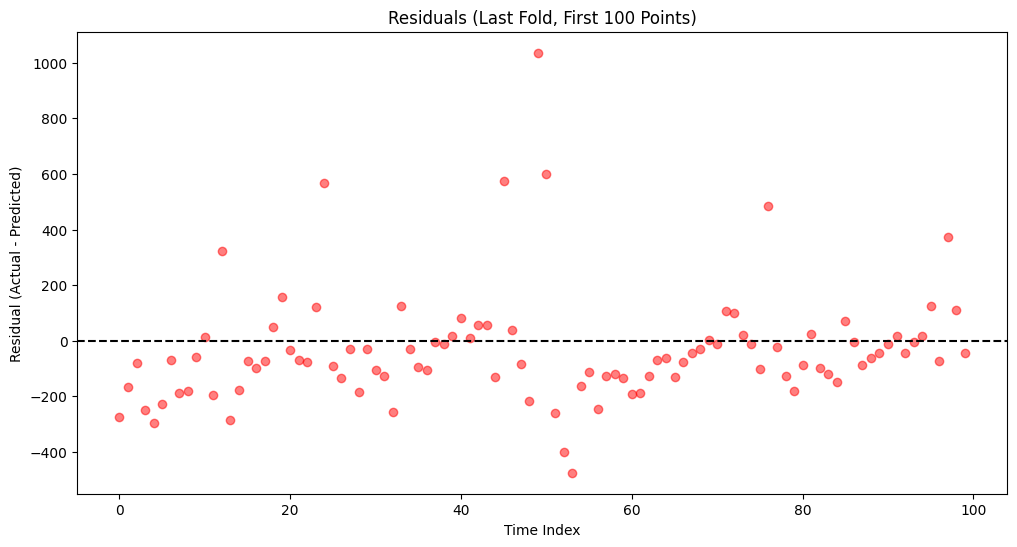

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns 

# Residual Plot
residuals = y_test.values - y_pred
plt.figure(figsize=(12, 6))
plt.scatter(range(len(residuals[:100])), residuals[:100], color='red', alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals (Last Fold, First 100 Points)')
plt.xlabel('Time Index')
plt.ylabel('Residual (Actual - Predicted)')
plt.show()
plt.savefig('residuals.png')
plt.close()

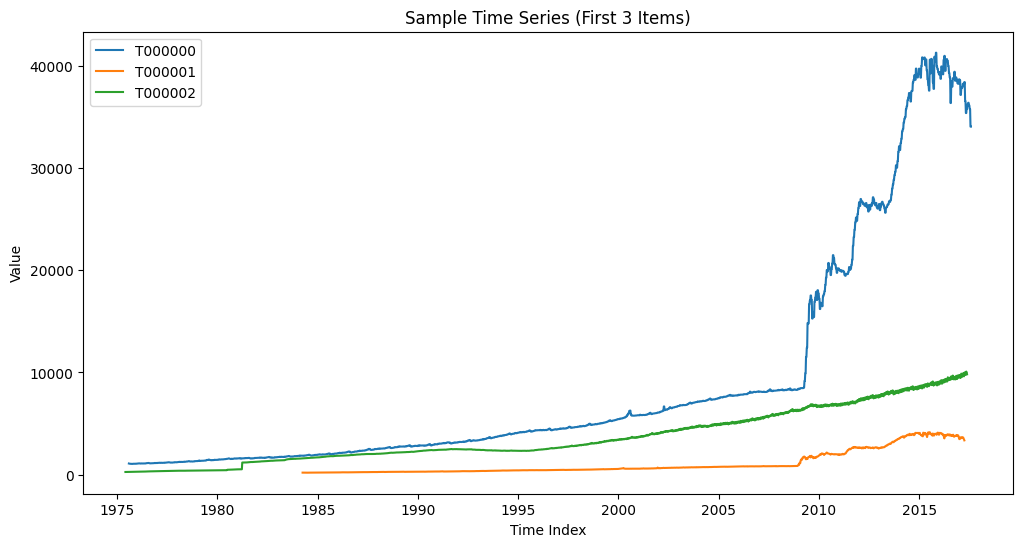

In [ ]:
#sample time series
sample_items = data['item_id'].unique()[:3]
plt.figure(figsize=(12, 6))
for item in sample_items:
    item_data = data[data['item_id'] == item]
    plt.plot(item_data['time_idx'], item_data['value'], label=item)
plt.title('Sample Time Series (First 3 Items)')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.show()
plt.close()

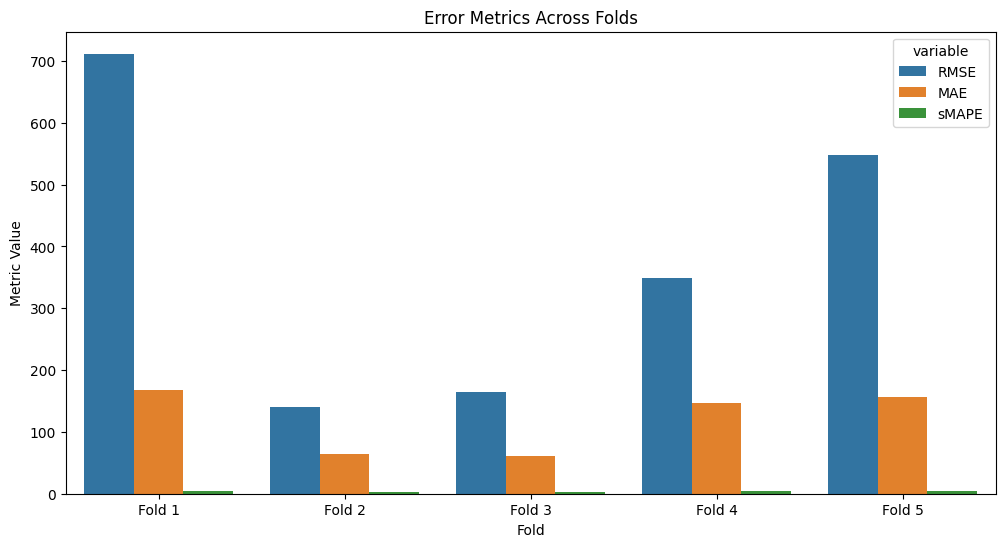

In [ ]:
# Error Metrics Across Folds
metrics_df = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(5)],
    'RMSE': rmse_scores,
    'MAE': mae_scores,
    'sMAPE': smape_scores
})
plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df.melt(id_vars=['Fold'], value_vars=['RMSE', 'MAE', 'sMAPE']), 
            x='Fold', y='value', hue='variable')
plt.title('Error Metrics Across Folds')
plt.ylabel('Metric Value')
plt.show()
plt.close()

In [ ]:
# --- Plotly Visualization ---
# Interactive Actual vs Predicted
import plotly.express as px
plot_df = pd.DataFrame({
    'Time Index': range(100),
    'Actual': y_test.values[:100],
    'Predicted': y_pred[:100]
})
fig = px.line(plot_df, x='Time Index', y=['Actual', 'Predicted'], 
              title='Actual vs Predicted Values (Last Fold, First 100 Points)')
fig.update_layout(yaxis_title='Value')
fig.show()

In [161]:
import shap
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

100%|===================| 369673/370143 [09:40<00:00]        

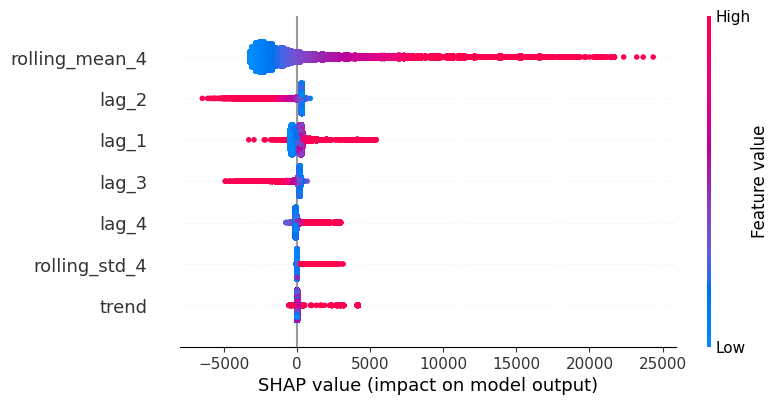

In [162]:
shap.plots.beeswarm(shap_values)

In [163]:
# --- Final Model ---
print("Training final model...")
final_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
final_model.fit(X, y)
joblib.dump(final_model, "forecasting_model.pkl")
print("Model saved as 'forecasting_model.pkl'")

Training final model...
Model saved as 'forecasting_model.pkl'
